In [ ]:
""" First close look at eye tracking, statistics, heatmaps ,etc.

Is looking predictive of where draw?

"""

In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from neuralmonkey.classes.session import Session
import matplotlib.pyplot as plt
from neuralmonkey.scripts.load_and_save_locally import load_and_preprocess_single_session
import neuralmonkey.utils.monkeylogic as mkl
from neuralmonkey.classes.session import load_session_helper, load_mult_session_helper
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
DATE = 220606
DATE = 231103
# DATE = 220901
animal = "Pancho"

In [ ]:
DATE = 230603
animal = "Diego"

In [4]:
# %matplotlib inline
# to help debug if times are misaligned.
MS = load_mult_session_helper(DATE, animal)
    


Searching using this string:
/mnt/Freiwald/ltian/recordings/*Pancho*/*231103*/**
Found this many paths:
2
---
/mnt/Freiwald/ltian/recordings/Pancho/231103/Pancho-231103-153735
---
/mnt/Freiwald/ltian/recordings/Pancho/231103/Pancho-231103-165303
session:  0
Beh Sessions that exist on this date:  {231103: [(1, 'gramstimpancho3f'), (2, 'gramstimpancho3f')]}
------------------------------
Loading this neural session: 0
Loading these beh expts: ['gramstimpancho3f']
Loading these beh sessions: [1]
Using this beh_trial_map_list: [(1, 0)]
Searching using this string:
/mnt/Freiwald/ltian/recordings/*Pancho*/*231103*/**
Found this many paths:
2
---
/mnt/Freiwald/ltian/recordings/Pancho/231103/Pancho-231103-153735
---
/mnt/Freiwald/ltian/recordings/Pancho/231103/Pancho-231103-165303
{'filename_components_hyphened': ['Pancho', '231103', '153735'], 'basedirs': ['/mnt/Freiwald/ltian/recordings/Pancho', '/mnt/Freiwald/ltian/recordings/Pancho/231103'], 'basedirs_filenames': ['231103', 'Pancho-231103-

### Load and quick plots of eye

In [5]:
SN = MS.SessionsList[0]

In [6]:
SN._CachedTrialOnset

{2: 0.0007819999991625082,
 3: 0.000992499999483698,
 4: 0.0018999999992956873,
 5: 0.0003080000005866168,
 6: 0.00023750000036670826,
 7: 0.00024230000053648837,
 8: 0.00023669999973208178,
 9: 0.0002444000001560198,
 10: 0.0002459999996062834,
 11: 0.0002500000009604264,
 13: 0.00023770000007061753,
 14: 0.00024449999909847975,
 15: 0.00024250000024039764,
 16: 0.00025300000015704427,
 17: 0.00024559999837947544,
 18: 0.00025740000091900583,
 19: 0.0002504999993107049,
 20: 0.00024159999884432182,
 21: 0.0002684999999473803,
 22: 0.00026479999905859586,
 23: 0.0002413000001979526,
 24: 0.00024189999930968042,
 25: 0.00024500000108673703,
 26: 0.0004293000001780456,
 27: 0.0002488999998604413,
 28: 0.00024370000028284267,
 29: 0.00023800000053597614,
 30: 0.00031240000134857837,
 31: 0.0002604000001156237,
 32: 0.0002482999989297241,
 33: 0.00023780000083206687,
 34: 0.0002386999985901639,
 35: 0.0002390000008745119,
 36: 0.00025379999897268135,
 37: 0.0002485999993950827,
 38: 0.0002

In [7]:
trials = SN.get_trials_list(True)
trials

[2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 

In [ ]:
SN.plot_stream(trial=trials[0], which="eyex")

In [ ]:
%matplotlib inline

In [ ]:
# Convert eye tracking to location


##### Load calibrate eye data

In [ ]:
SN.load_behavior()

In [ ]:
# Developiung code to optimize alignment beween tdt and ml2.
times_tdt, vals_tdt, fs_tdt, times_ml2, vals_ml2, fs_ml2, fd = SN._beh_extract_eye_raw(100)
vals_tdt_calibrated = SN._beh_extract_eye_calibrate_raw(vals_tdt, fd)

SN._BehEyeAlignOffset = None

SN._beh_extract_eye_return_alignment_offset()

-- loaded presaved data: /mnt/Freiwald_kgupta/kgupta/macaque_data/Pancho/231103/231103_153237_gramstimpancho3f_Pancho_1.pkl
trials: [18, 34, 50, 66, 82, 98, 114, 130, 146, 162, 178, 194, 211, 227, 243, 260]
This is 10th percentile of rms diff between ml2 and tdt pix values.. lower the better
[0.69690284]
This is 10th percentile of rms diff between ml2 and tdt pix values.. lower the better
[1.19782748]
This is 10th percentile of rms diff between ml2 and tdt pix values.. lower the better
[1.01145584]
This is 10th percentile of rms diff between ml2 and tdt pix values.. lower the better
[0.77973787]
This is 10th percentile of rms diff between ml2 and tdt pix values.. lower the better
[1.30334015]
This is 10th percentile of rms diff between ml2 and tdt pix values.. lower the better
[1.22674111]
This is 10th percentile of rms diff between ml2 and tdt pix values.. lower the better
[1.27827391]
This is 10th percentile of rms diff between ml2 and tdt pix values.. lower the better
[1.35139281]
T

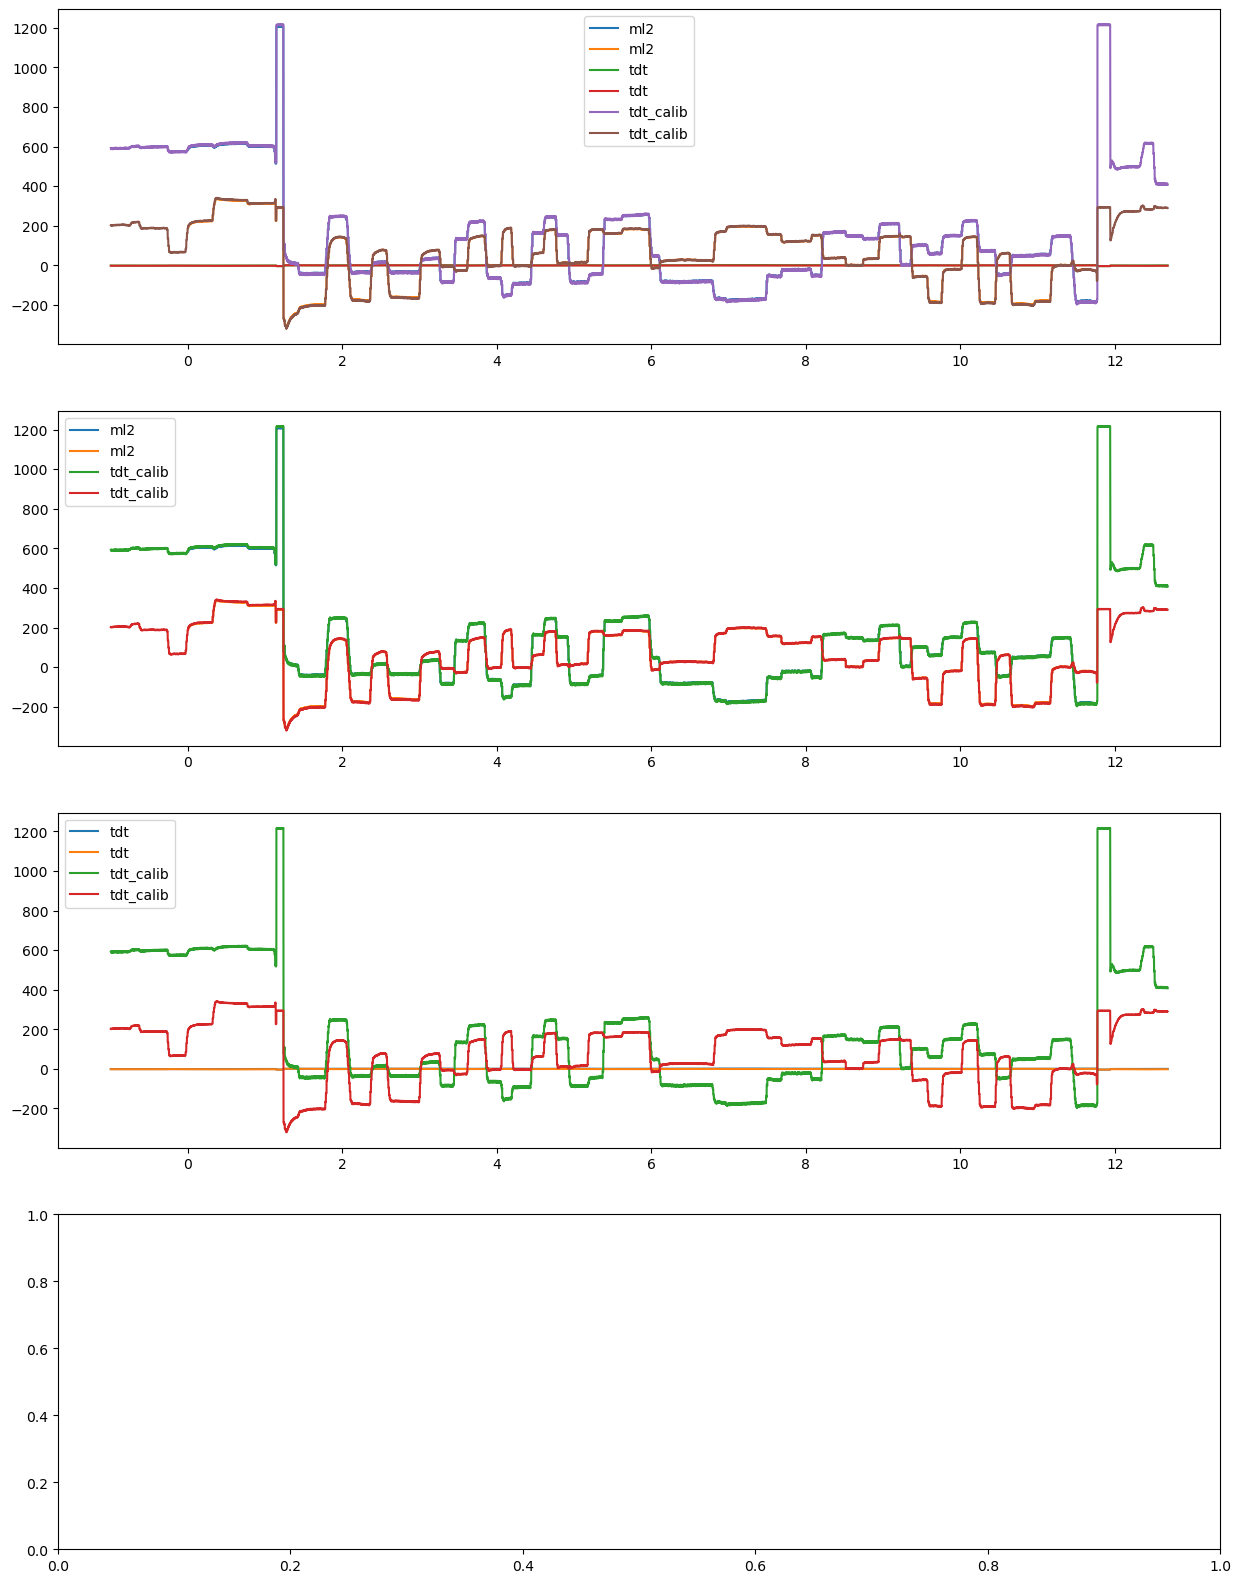

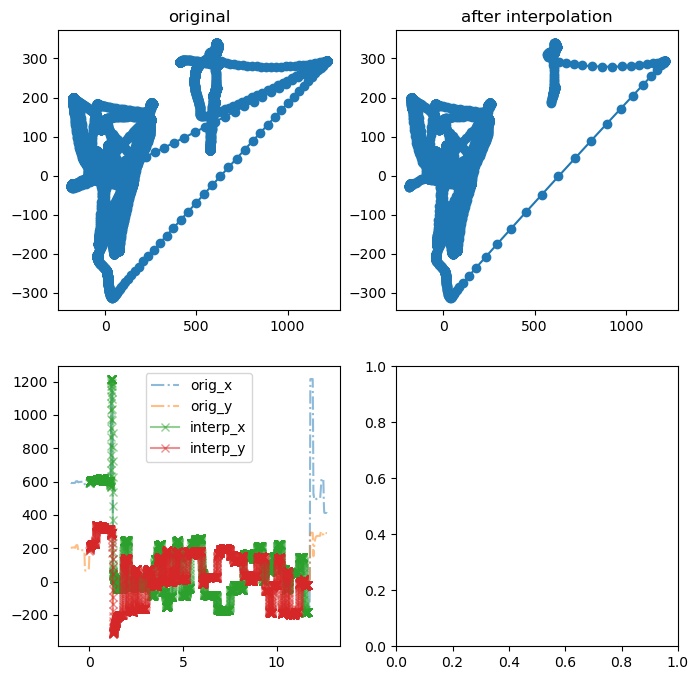

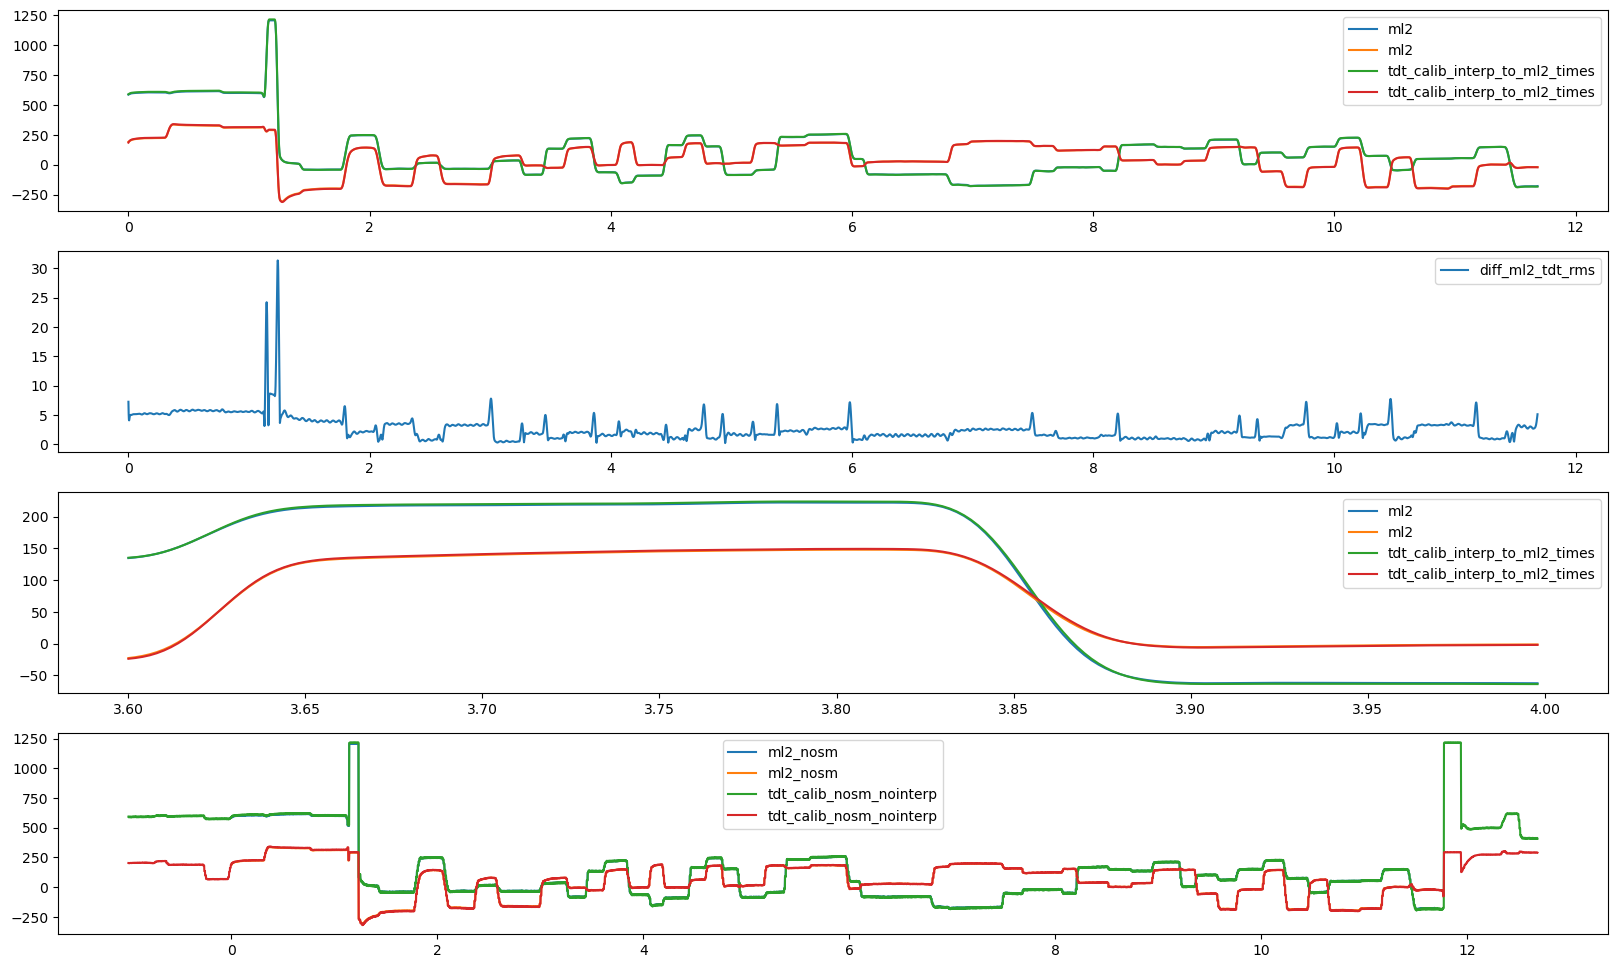

In [9]:
%matplotlib inline
CHECK_TDT_ML2_MATCH = True
apply_empirical_offset = True
return_all = False
times_tdt, vals_tdt_calibrated = SN.beh_extract_eye_good(trials[100], CHECK_TDT_ML2_MATCH=CHECK_TDT_ML2_MATCH, PLOT=True, 
                                                         apply_empirical_offset=apply_empirical_offset, return_all=return_all)

In [8]:
apply_empirical_offset = True
PLOT = False
CHECK_TDT_ML2_MATCH = True
for trial in SN.get_trials_list(True)[::10]:
    print(trial)
    times_tdt, vals_tdt_calibrated = SN.beh_extract_eye_good(trial, CHECK_TDT_ML2_MATCH=CHECK_TDT_ML2_MATCH, PLOT=PLOT, apply_empirical_offset=apply_empirical_offset)

2



KeyboardInterrupt



### [FOR KEDAR] load eye tracking and plot over behavior

In [ ]:
def _plot_eye_trace(times, vals, ax, color="b"):
    ax.plot(vals[:,0], vals[:,1], "-k", alpha=0.3)
    ax.scatter(vals[:,0], vals[:,1], c=times, alpha=0.5, marker="o")    


In [ ]:
################ PARAMS
sn = MS.SessionsList[0]
PLOT_SM = True # smoothed?
trial = sn.get_trials_list(True)[-1]

############### RUN
times_tdt, vals_tdt_calibrated, fs_tdt, vals_tdt_calibrated_sm = sn.beh_extract_eye_good(trial, PLOT=True, return_all=True);

if PLOT_SM:
    VALS = vals_tdt_calibrated_sm
else:
    VALS = vals_tdt_calibrated
    
############### 1) Plot during planning
# Overlay on task and beh
fig, ax = plt.subplots()
sn.plot_taskimage(ax, trial)

# sn.Datasetbeh.plot_strokes([VALS], ax)
# _plot_eye_trace(VALS, ax, "r")

# keep just times during "planning"
dict_event_times = sn.events_get_time_sorted(trial)[0]
t1 = dict_event_times["stim_onset"]
t2 = dict_event_times["go"]

inds = (times_tdt>=t1) & (times_tdt<=t2)
times_this = times_tdt[inds]
vals_this = VALS[inds]

# sn.Datasetbeh.plot_strokes([vals_this], ax, single_color="r", alpha=0.5)
_plot_eye_trace(times_this, vals_this, ax)

############### 2) Plot during strokes
# Overlay on task and beh
fig, ax = plt.subplots()
sn.plot_taskimage(ax, trial)


dict_event_times = sn.events_get_time_sorted(trial)[0]
ons, offs = sn.strokes_extract_ons_offs(trial)
t1 = dict_event_times["go"]
t2 = offs[-1]

inds = (times_tdt>=t1) & (times_tdt<=t2)
times_this = times_tdt[inds]
vals_this = VALS[inds]

# sn.Datasetbeh.plot_strokes([vals_this], ax, single_color="r", alpha=0.5)
_plot_eye_trace(times_this, vals_this, ax)


In [ ]:
# Extract task stroke shapes, including their locations, etc.
ind = sn.datasetbeh_trial_to_datidx(trial)
tokens_task = sn.Datasetbeh.taskclass_tokens_extract_wrapper(ind, "task", plot=True)
tokens_beh = sn.Datasetbeh.taskclass_tokens_extract_wrapper(ind, "beh", plot=False)

# 

In [ ]:
# Tokens holds each prim (either beh or task) as a discrete object

# This gives useful features for the first prim in the task
tokens_task[0]

In [ ]:
### to get times of events in the trial:
dict_event_times = sn.events_get_time_sorted(trial)

# - you can pick events form tjhis list:
print(sn.events_default_list_events())

# -- such as this:
dict_event_times = sn.events_get_time_sorted(trial, list_events=['samp', 'go', 'first_raise'])
print(dict_event_times)

### to get times of strokes
ons, offs = sn.strokes_extract_ons_offs(trial)
print(ons, offs)

In [ ]:
# To get spatial coordinates of task strokes
sn.strokes_task_extract(trial)